In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import math
import torch._dynamo
torch._dynamo.config.suppress_errors = True


In [2]:
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=10,
        spline_order=4,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.ReLU,
        grid_eps=0.01,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(2, 0, 1)  # (out_features, in_features, grid_size + spline_order)

        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        x = x.to(self.grid.device)  # Move x to the same device as grid
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
    
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=0.5, regularize_entropy=0.5):
        """
        Compute the regularization loss.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


🔧 Using device: cuda

TESTING MODEL 1
Loading model from: /kaggle/input/resnet18withkan9393/pytorch/default/1/resnet18withkan9393.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded successfully!
📊 Dataset: 24981 samples, 22 classes
Classes: ['anthracnose_Cashew', 'bacterial blight_Cassava', 'brown spot_Cassava', 'fall armyworm_Maize', 'grasshoper_Maize', 'green mite_Cassava', 'gumosis_Cashew', 'healthy_Cashew', 'healthy_Cassava', 'healthy_Maize', 'healthy_Tomato', 'leaf beetle_Maize', 'leaf blight_Maize', 'leaf blight_Tomato', 'leaf curl_Tomato', 'leaf miner_Cashew', 'leaf spot_Maize', 'mosaic_Cassava', 'red rust_Cashew', 'septoria leaf spot_Tomato', 'streak virus_Maize', 'verticulium wilt_Tomato']
🔍 Calculating per-class accuracies...
Processed batch 0/49
Processed batch 10/49
Processed batch 20/49
Processed batch 30/49
Processed batch 40/49
Overall Accuracy: 95.09%

TESTING MODEL 2
Loading model from: /kaggle/input/resnet18kan-raw-9093valacc/pytorch/default/1/Resnet18withKANRAW9093.pth
✅ Model loaded successfully!
📊 Dataset: 6271 samples, 22 classes
Classes: ['anthracnose_Cashew', 'bacterial blight_Cassava', 'brown spot_Cassava', 'fall armyworm_M

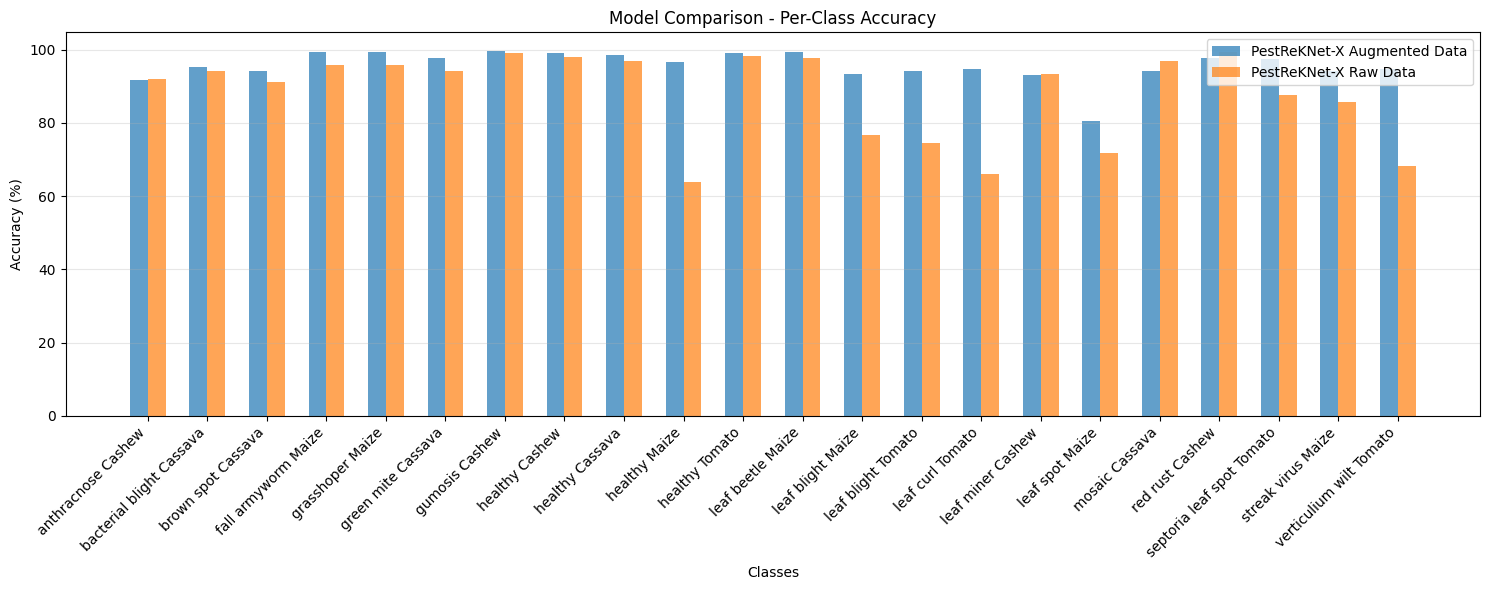


💾 Results saved to 'model_comparison_results.pth'
✅ Variables stored: model1_accuracies, model2_accuracies, class_names


In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def load_model(model_path, num_classes=22, device='cuda'):
    """Load ResNet18 + KANLinear model"""
    print(f"Loading model from: {model_path}")
    
    # Define model architecture
    model = models.resnet18(pretrained=False)
    model.fc = KANLinear(in_features=model.fc.in_features, out_features=num_classes)
    
    # Load weights
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
    return model

def calculate_per_class_accuracy(model, test_loader, num_classes, device):
    """Calculate accuracy for each class"""
    model.eval()
    
    # Initialize counters
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)
    all_predictions = []
    all_targets = []
    
    print("🔍 Calculating per-class accuracies...")
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            
            # Store for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Calculate per-class accuracy
            correct = (predictions == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
            
            if batch_idx % 10 == 0:
                print(f"Processed batch {batch_idx}/{len(test_loader)}")
    
    # Calculate accuracies
    class_accuracies = []
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = 100.0 * class_correct[i] / class_total[i]
            class_accuracies.append(accuracy.item())
        else:
            class_accuracies.append(0.0)
    
    overall_accuracy = 100.0 * sum(class_correct) / sum(class_total)
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    
    return class_accuracies, all_predictions, all_targets

def setup_dataset(dataset_path, batch_size=512):
    """Setup test dataset and dataloader"""
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = datasets.ImageFolder(dataset_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"📊 Dataset: {len(test_dataset)} samples, {len(test_dataset.classes)} classes")
    print(f"Classes: {test_dataset.classes}")
    
    return test_loader, test_dataset.classes
    

def simple_plot(model1_accuracies, model2_accuracies, class_names, model1_name="Model 1", model2_name="Model 2"):
    x = np.arange(len(class_names))
    width = 0.30
    
    plt.figure(figsize=(15, 6))
    plt.bar(x - width/2, model1_accuracies, width, label=model1_name, alpha=0.7)
    plt.bar(x + width/2, model2_accuracies, width, label=model2_name, alpha=0.7)
    
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Comparison - Per-Class Accuracy')
    plt.xticks(x, [name.replace('_', ' ') for name in class_names], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def main():
    """Main execution function"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔧 Using device: {device}")
    
    MODEL1_PATH = '/kaggle/input/resnet18withkan9393/pytorch/default/1/resnet18withkan9393.pth'
    MODEL2_PATH = '/kaggle/input/resnet18kan-raw-9093valacc/pytorch/default/1/Resnet18withKANRAW9093.pth'
    DATASET1_PATH = '/kaggle/input/pest-data/Testing_Data'
    DATASET2_PATH = '/kaggle/input/split-clean-raw-data-test2/other/default/1/Testing'

    MODEL1_NAME = "PestReKNet-X Augmented Data"
    MODEL2_NAME = "PestReKNet-X Raw Data"
    
    num_classes = 22
    batch_size = 512
    
    try:
        print("\n" + "="*50)
        print("TESTING MODEL 1")
        print("="*50)
        
        # Load Model 1
        model1 = load_model(MODEL1_PATH, num_classes, device)
        
        # Setup Dataset 1
        test_loader1, class_names1 = setup_dataset(DATASET1_PATH, batch_size)
        
        # Calculate accuracies for Model 1
        model1_accuracies, pred1, true1 = calculate_per_class_accuracy(
            model1, test_loader1, num_classes, device
        )
        
        print("\n" + "="*50)
        print("TESTING MODEL 2")
        print("="*50)
        
        # Load Model 2
        model2 = load_model(MODEL2_PATH, num_classes, device)
        
        # Setup Dataset 2
        test_loader2, class_names2 = setup_dataset(DATASET2_PATH, batch_size)
        
        # Calculate accuracies for Model 2
        model2_accuracies, pred2, true2 = calculate_per_class_accuracy(
            model2, test_loader2, num_classes, device
        )
        
        print("\n" + "="*50)
        print("RESULTS COMPARISON")
        print("="*50)
        
        # Print detailed results
        print(f"\n{MODEL1_NAME} Per-Class Accuracies:")
        for i, (class_name, acc) in enumerate(zip(class_names1, model1_accuracies)):
            print(f"  {i:2d}. {class_name:<25}: {acc:6.2f}%")
        
        print(f"\n{MODEL2_NAME} Per-Class Accuracies:")
        for i, (class_name, acc) in enumerate(zip(class_names2, model2_accuracies)):
            print(f"  {i:2d}. {class_name:<25}: {acc:6.2f}%")
        
        # Calculate overall statistics
        model1_avg = np.mean(model1_accuracies)
        model2_avg = np.mean(model2_accuracies)
        
        print(f"\n📈 SUMMARY:")
        print(f"{MODEL1_NAME} - Average Accuracy: {model1_avg:.2f}%")
        print(f"{MODEL2_NAME} - Average Accuracy: {model2_avg:.2f}%")
        print(f"Difference: {abs(model1_avg - model2_avg):.2f}%")
        
        simple_plot(model1_accuracies, model2_accuracies, class_names1, MODEL1_NAME, MODEL2_NAME)
        
        globals()['model1_accuracies'] = model1_accuracies
        globals()['model2_accuracies'] = model2_accuracies
        globals()['class_names'] = class_names1
        globals()['model1_name'] = MODEL1_NAME
        globals()['model2_name'] = MODEL2_NAME
        
        results = {
            'model1_name': MODEL1_NAME,
            'model2_name': MODEL2_NAME,
            'class_names': class_names1,
            'model1_accuracies': model1_accuracies,
            'model2_accuracies': model2_accuracies,
            'model1_avg': model1_avg,
            'model2_avg': model2_avg
        }
        
        torch.save(results, 'model_comparison_results.pth')
        print(f"\n💾 Results saved to 'model_comparison_results.pth'")
        print(f"✅ Variables stored: model1_accuracies, model2_accuracies, class_names")
        
        return results
        
    except Exception as e:
        print(f"❌ Error during execution: {e}")
        raise

if __name__ == "__main__":
    results = main()